In [169]:
import os
import pickle
import librosa
import numpy as np
import pandas as pd
import seaborn as sns

import scipy.io.wavfile as wav
from collections import Counter
from matplotlib import pyplot as plt
from IPython.display import clear_output

from librosa.feature import melspectrogram
from librosa import load, logamplitude

np.set_printoptions(linewidth=250, suppress=True)

%matplotlib inline

In [95]:
def find_durations(data, answer):
    durations = {}
    for i, author in enumerate(set(data.authors)):
        for word in data[data.authors == author].words:
            #print(os.listdir('dataset/b{}'.format(author)))
            wname = 'speech_data/b{}/{}.wav'.format(author, answer[word])
            if not os.path.isfile(wname):
                fname = 'speech_data/b{}/{}.mp3'.format(author, answer[word])
                oname = '/tmp/file.wav'
                !lame '{fname}' --decode '{oname}' --quiet
                !cp '{oname}' '{wname}'
            sample_rate, timesequence = wav.read(wname)
            if len(timesequence.shape) > 1:
                timesequence = timesequence[:, 0]
            durations[(author, word)] = timesequence.size / sample_rate
    return durations

In [ ]:
durations = find_durations(data, answer)

/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


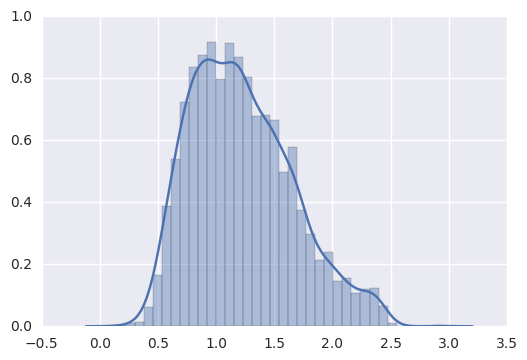

In [125]:
sns.distplot(list(durations.values()))

Can't init infile 'speech_data/bMshak/2797622731408234712.mp3'
Can't init infile 'speech_data/bszurszuncik/-4947795336151861975.mp3'
Can't init infile 'speech_data/bszurszuncik/-7183626479791404317.mp3'
Can't init infile 'speech_data/bdisappointed/-950460213665267749.mp3'
Can't init infile 'speech_data/bdisappointed/6027766216114243336.mp3'
Can't init infile 'speech_data/bzhivaya/6142747929449266446.mp3'
Can't init infile 'speech_data/b1640max/2324524844955058754.mp3'
Can't init infile 'speech_data/b1640max/3063377735457069913.mp3'
Can't init infile 'speech_data/bEgde/-3318315914358233874.mp3'


In [131]:
def retrieve_sound_arrays(data, answer, unified_sample_rate=22050):
    sequences = {}
    #bar = ProgressBar()
    for author in set(data.authors):
        for word in data[data.authors == author].words:
            fname = 'speech_data/b{}/{}.wav'.format(author, answer[word])
            #oname = '/tmp/file.wav'
            #!lame '{fname}' --decode '{oname}' --quiet
            if os.path.isfile(fname):
                timesequence, sample_rate = librosa.load(fname)
                if len(timesequence.shape) > 1:
                    timesequence = timesequence[:, 0]
                if sample_rate != 22050:
                    unified_timesequence = librosa.resample(np.asarray(timesequence, np.float32),
                                                            sample_rate,
                                                            unified_sample_rate)
                else:
                    unified_timesequence = np.array(timesequence, np.float32)
                sequences[(author, word)] = timesequence
            else:
                sequences[(author, word)] = None
            
    return sequences

In [39]:
data = pd.DataFrame.from_csv('data.csv')
answer = pickle.load(open('dataset/ajnsdjasnd.pcl','rb'))

In [ ]:
durations = find_durations(data, answer)

In [118]:
!ls speech_data/b1999

3431577249605052561.mp3  3431577249605052561.wav


In [132]:
sequences = retrieve_sound_arrays(data, answer, unified_sample_rate=22050)

In [135]:
lengths = np.array([len(arr) for arr in sequences.values() if arr is not None])

In [ ]:
lengths = lengths / 22050

In [138]:
max_duration= 1.0
unified_sample_rate=22050
n_mels=128
flush=True
eps=0.0

In [139]:
max_samples = int(unified_sample_rate * max_duration)
mask = np.ones(len(data), dtype=np.bool)

matrix_index_counter = 0

In [140]:
for index, row in data.iterrows():
    next_timesequence = sequences[(row['authors'], row['words'])]
    if next_timesequence is None:
        # there is no data for that track -- skip it
        mask[index] = False
    elif len(next_timesequence) / unified_sample_rate < max_duration - eps:
        # track is too short -- skip it too
        mask[index] = False
    else:
        # track is ok
        continue

In [141]:
valid_data = data.ix[mask]

In [146]:
valid_count = len(valid_data)
big_matrix = np.zeros((valid_count, max_samples), dtype=np.float32)
track_lengths = np.zeros(valid_count, dtype=np.int)
matrix_indices = np.arange(valid_count)

In [147]:
test_melspectrogram = melspectrogram(np.ones(max_samples), sr=unified_sample_rate, n_mels=n_mels)
spectrograms = np.zeros((valid_count,) + test_melspectrogram.shape)

In [148]:
track_counter = 0
#bar = ProgressBar()
for _, row in valid_data.iterrows():
    next_timesequence = sequences[(row['authors'], row['words'])]
    # hack to handle a little shorter tracks
    minsize_clipper = min(next_timesequence.size, max_samples)
    big_matrix[track_counter, :minsize_clipper] = next_timesequence[:minsize_clipper]

    spectrograms[track_counter, ...] = melspectrogram(np.pad(next_timesequence[:minsize_clipper],
                                                     (0, max_samples - minsize_clipper),
                                                     mode='constant'),
                                              sr=unified_sample_rate, n_mels=n_mels)
    track_counter += 1

In [149]:
vd = pd.concat([valid_data, pd.Series()])

/anaconda3/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning: unorderable types: str() < int(), sort order is undefined for incomparable objects
  result = result.union(other)


In [ ]:
pd.Series

In [150]:
valid_data

,words,authors,links
0,Бенилюкс,ivga,http://ru.forvo.com/word/%D0%B1%D0%B5%D0%BD%D0...
1,большая гармония гласных,rutre15,http://ru.forvo.com/word/%D0%B1%D0%BE%D0%BB%D1...
2,малая гармония гласных,rutre15,http://ru.forvo.com/word/%D0%BC%D0%B0%D0%BB%D0...
3,бумажный стаканчик,Patient228,http://ru.forvo.com/word/%D0%B1%D1%83%D0%BC%D0...
4,бумажный стаканчик,rutre15,http://ru.forvo.com/word/%D0%B1%D1%83%D0%BC%D0...
5,будьте любезны,Patient228,http://ru.forvo.com/word/%D0%B1%D1%83%D0%B4%D1...
6,будьте любезны,rutre15,http://ru.forvo.com/word/%D0%B1%D1%83%D0%B4%D1...
7,улыбчивые,lidadusya,http://ru.forvo.com/word/%D1%83%D0%BB%D1%8B%D0...
8,стаканчик мороженого,Patient228,http://ru.forvo.com/word/%D1%81%D1%82%D0%B0%D0...
9,стаканчик мороженого,lidadusya,http://ru.forvo.com/word/%D1%81%D1%82%D0%B0%D0...


In [167]:
def build_array_and_dataframe(data, sequences, fname="valid_data", max_duration=0.5,
                              unified_sample_rate=22050, n_fft=128, flush=True, eps=0.0):
    max_samples = int(unified_sample_rate * max_duration)
    mask = np.ones(len(data), dtype=np.bool)
        
    matrix_index_counter = 0
    for index, row in data.iterrows():
        next_timesequence = sequences[(row['authors'], row['words'])]
        if next_timesequence is None:
            # there is no data for that track -- skip it
            mask[index] = False
        elif len(next_timesequence) / unified_sample_rate < max_duration - eps:
            # track is too short -- skip it too
            mask[index] = False
        else:
            # track is ok
            continue
    
    valid_data = data.ix[mask]
    valid_count = len(valid_data)
    big_matrix = np.zeros((valid_count, max_samples), dtype=np.float32)
    track_lengths = np.zeros(valid_count, dtype=np.int)
    matrix_indices = np.arange(valid_count)
    
    # find how many frames return melspectrogram at chosen duration
    test_melspectrogram = melspectrogram(np.ones(max_samples), sr=unified_sample_rate, n_fft=n_fft)
    spectrograms = np.zeros((valid_count,) + test_melspectrogram.shape)

    track_counter = 0
    #bar = ProgressBar()
    for _, row in valid_data.iterrows():
        next_timesequence = sequences[(row['authors'], row['words'])]
        # hack to handle a little shorter tracks
        minsize_clipper = min(next_timesequence.size, max_samples)
        big_matrix[track_counter, :minsize_clipper] = next_timesequence[:minsize_clipper]
        
        S = melspectrogram(np.pad(next_timesequence[:minsize_clipper],
                                                         (0, max_samples - minsize_clipper),
                                                         mode='constant'),
                                                  sr=unified_sample_rate, n_fft=n_fft)
        logS = logamplitude(S, ref_power=np.max)
        spectrograms[track_counter, ...] = logS
        track_counter += 1
        
    valid_data.loc[:,'matrix_index'] = pd.Series(matrix_indices, index=valid_data.index)
    if flush:
        valid_data.to_csv("{}.csv".format(fname))
        mat_spec_dict = {
            'timesequences': big_matrix,
            'spectrograms': spectrograms
        }
        np.savez('{}'.format(fname), mat_spec_dict)
    return valid_data, mat_spec_dict

In [170]:
vdata, vmatrix = build_array_and_dataframe(data, sequences)

/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:476: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [171]:
def retrieve_preprocessed_data(fname='valid_data'):
    data_from_file = np.load('{}.npz'.format(fname))
    data_table = pd.read_csv('{}.csv'.format(fname))
    data_dict = np.asscalar(data_from_file['arr_0'])
    return data_table, data_dict['timesequences'], data_dict['spectrograms']

In [172]:
valid_data, valid_timesequences, valid_spectrograms = retrieve_preprocessed_data('valid_data')

In [160]:
lengths

array([ 1.05904762,  1.32027211,  1.71210884, ...,  1.73823129,  1.60761905,  0.56272109])

In [161]:
valid_spectrograms.shape

(4088, 128, 22)

In [159]:
type(np.asscalar(vdata_from_file['arr_0']))

NameError: name 'vdata_from_file' is not defined

In [144]:
data.loc[np.array((data['authors'] == lst[0][0]) & (data['words'] == lst[0][1]))]

,words,authors,links
6767,посещать,arina,http://ru.forvo.com/word/%D0%BF%D0%BE%D1%81%D0...


KeyError: 0

In [30]:
durations = find_durations(data, answer)

In [162]:
dur_values = np.array(list(durations.values()))

/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


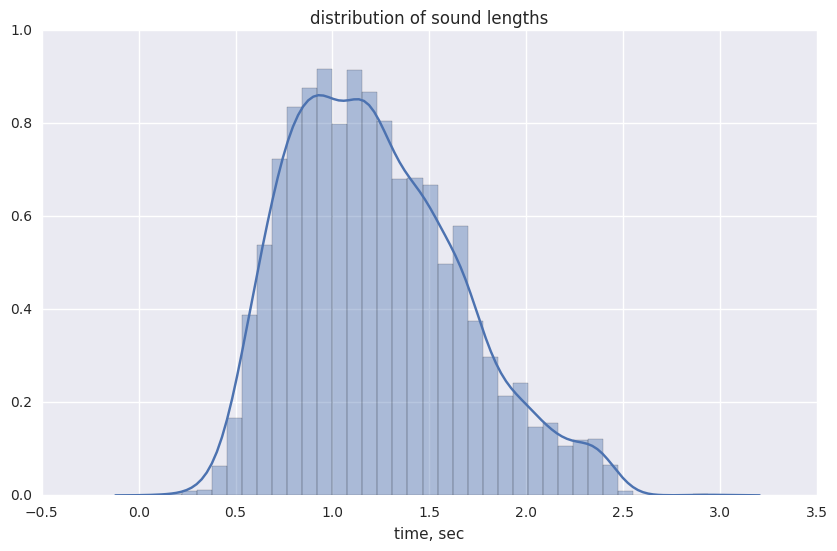

In [163]:
sns.plt.figure(figsize=(10, 6))
sns.plt.title('distribution of sound lengths')
sns.plt.xlabel('time, sec')
sns.distplot(lengths)
#sns.plt.savefig('soundlength_distribution.png', dpi=150)

In [164]:
np.percentile(lengths, 5)

0.6149659863945578

In [72]:
dur_values.max()

3.2271882086167802

In [7]:
data = pd.DataFrame.from_csv('data.csv')
answer = pickle.load(open('dataset/ajnsdjasnd.pcl','rb'))

In [8]:
ex_author = data.authors[0]
ex_word = data[data.authors == ex_author].words[0]
fname = 'dataset/b{}/{}.mp3'.format(ex_author, answer[ex_word])

In [14]:
librosa.load(fname)

NoBackendError: 

In [ ]:
def get_spectgorgamm(fname): 
    y, sr = librosa.load(fname) 
    S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128) 
    log_S = librosa.logamplitude(S, ref_power=np.max) 
    return log_S[:,:1200]

In [159]:
3.5 * 22050 * 4 * 7300 / 1024 / 1024

2149.1146087646484

In [2]:
predict()

NameError: name 'predict' is not defined